[View in Colaboratory](https://colab.research.google.com/github/Fede2000/school_of_ai_KaggleTeam_GS-Salt-Identification-Challenge/blob/master/colab/School_of_Ai_Colab_V1.ipynb)

# ReadMe

To start collaborating with this notebook, *leave a comment with your email*.

TODO:


*   write a first model
*   upload our first submission



# Imports

In [0]:
'''!pip install kaggle
from google.colab import files
files.upload()
'''

    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 235kB 5.3MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"schoolofai","key":"92c517a0a56463814199d84ea698fd1e"}'}

In [0]:
'''

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c tgs-salt-identification-challenge

!mkdir train
!mkdir test

%cd train
!unzip ../train.zip
%cd ../test
%ls
!unzip ../test.zip
%cd ../

%ls'''


import gc
import glob
import os
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd

from keras.callbacks import *
from keras.models import load_model
from tqdm import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')

# Data processing

In [0]:
class SaltParser(object):

    """
    Parser for Salt Competition.
    """

    def __init__(self,
                 data_src='../input/',
                 image_size=(128, 128),
                 pad_images=False,
                 grayscale=True,
                 load_test_data=True):

        self.data_src = data_src
        self.image_size = image_size
        self.pad_images = pad_images
        self.grayscale = grayscale
        self.load_test_data = load_test_data

        self.train_df = None
        self.test_df = None
        self.padding_pixels = None

        self.X_train = []
        self.y_train = []
        self.X_test = []

        self.orig_image_size = (101, 101)
        
        """
        # Arguments:
        
            data_src: directory containing data
            image_size: tuple specifying final image size
            pad_images: whether images should be padded or resized
            grayscale: whether to load images as grayscale
            load_test_data: whether to load test data
            
        """

    def initialize_data(self):
        
        """
        Initialize processing by loading .csv files.
        """

        train_df = pd.read_csv('{}train.csv'.format(self.data_src),
                               usecols=[0], index_col='id')
        depths_df = pd.read_csv('{}depths.csv'.format(self.data_src),
                                index_col='id')

        self.train_df = train_df.join(depths_df)
        self.test_df = depths_df[~depths_df.index.isin(train_df.index)]

        return

    def load_data(self):
        
        """
        Load images and masks from training set.
        
        # Returns:
            self.X_train: np.array of training images
            self.y_train: np.array of training masks
            self.X_test: np.array of test images
        """
        if not self.load_test_data:
          print('Loading training set.')
          # Loop over ids in train_df
          for i in tqdm(self.train_df.index):
              # Load image and mask according to ID
              img_src = '{}train/images/{}.png'.format(self.data_src, i)
              mask_src = '{}train/masks/{}.png'.format(self.data_src, i)
              # Specify if image should be loaded in grayscale.
              if self.grayscale:
                  img_temp = cv2.imread(img_src, 0)
              else:
                  img_temp = cv2.imread(img_src)
              # Load mask
              mask_temp = cv2.imread(mask_src, 0)
              # Resize or pad image and mask
              if self.orig_image_size != self.image_size:
                  if self.pad_images:
                      img_temp = self.__pad_image(img_temp)
                      mask_temp = self.__pad_image(mask_temp)
                  else:
                      img_temp = cv2.resize(img_temp, self.image_size)
                      mask_temp = cv2.resize(mask_temp, self.image_size)
              # Append processed image and mask
              self.X_train.append(img_temp)
              self.y_train.append(mask_temp)

          # Transform into arrays
          self.X_train = np.asarray(self.X_train)
          self.y_train = np.asarray(self.y_train)
          # If images were loaded as grayscale, they are loaded as (HxW) arrays
          # Dimensions must be expanded for the model to be trained.
          if self.grayscale:
              self.X_train = np.expand_dims(self.X_train, -1)
          # Mask must be expanded obligatorily, as they are 1-channel by default.
          self.y_train = np.expand_dims(self.y_train, -1)

          # Output information about training set.
          print('Training set ready.')
          print('X_train shape: {}'.format(self.X_train.shape))
          print('y_train shape: {}'.format(self.y_train.shape))
          print('X_train - min: {}, max: {}'.format(
              np.min(self.X_train), np.max(self.X_train)))
          print('y_train - min: {}, max: {}'.format(
              np.min(self.y_train), np.max(self.y_train)))

        # Load test data.
        # Perform similar steps to the training processing part,
        # but there are no masks to be loaded.
        if self.load_test_data:
            print('Loading test set.')
            for i in tqdm(self.test_df.index):
                img_src = '{}test/images/{}.png'.format(self.data_src, i)
                if self.grayscale:
                    img_temp = cv2.imread(img_src, 0)
                else:
                    img_temp = cv2.imread(img_src)
                if self.orig_image_size != self.image_size:
                    if self.pad_images:
                        img_temp = self.__pad_image(img_temp)
                    else:
                        img_temp = cv2.resize(img_temp, self.image_size)
                self.X_test.append(img_temp)

            self.X_test = np.asarray(self.X_test)
            if self.grayscale:
                self.X_test = np.expand_dims(self.X_test, -1)

            print('Test set ready.')
            print('X_test shape: {}'.format(self.X_test.shape))
            print('X_test - min: {}, max: {}'.format(
                np.min(self.X_test), np.max(self.X_test)))

            return self.X_test, self.test_df

        return self.X_train, self.y_train

    def compute_coverage(self):
        
        """
        Compute salt coverage of each mask. This will serve as a basis for 
        stratified split between training and validation sets.
        
        # Returns:
            self.train_df: training DF containing coverage information.
        """

        print('Compute mask coverage for each observation.')

        def cov_to_class(val):
            for i in range(0, 11):
                if val * 10 <= i:
                    return i

        # Output percentage of area covered by class
        self.train_df['coverage'] = np.mean(self.y_train / 255., axis=(1, 2))
        # Coverage must be split into bins, otherwise stratified split will not be possible,
        # because each coverage will occur only once.
        self.train_df['coverage_class'] = self.train_df.coverage.map(
            cov_to_class)

        return self.train_df
      
  


    def predictions_rle_encode(self,
                               y_pred_test,
                               confidence_threshold_best):
        
        """
        Run Length Encoding of predictions.
        This is needed for submission output.
        
        # Arguments:
            y_pred_test: model predictions
            confidence_threshold_best: confidence threshold, according to which
                masks are set to 1/0.
        # Returns:
            y_test_pred_rle: RLEncoded predictions.
        """

        # If images were padded, this padding must now be removed.
        # Otherwise encoding method will fail to properly encode predictions and
        # score will be bad.
        if self.pad_images:
            print('Remove padding from images.')
            y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
                0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]
            y_pred_test = y_pred_test[:, y_min_pad:-
                                      y_max_pad, x_min_pad:-x_max_pad, 0]
            
        # Situation is similar for previously resized images.
        # They must be resized again to their original size before encoding.
        else:
            y_pred_test = np.asarray([cv2.resize(x, self.orig_image_size)
                                      for x in y_pred_test])

        assert y_pred_test.shape == (18000, 101, 101), '\
        Test predictions shape must be equal to (18000, 101, 101).'

        print('Test predictions shape: {}'.format(y_pred_test.shape))

        # Perform mask predictions binarization and RLEncoding. 
        y_test_pred_rle = {idx:
                           rle_encode(y_pred_test[i] > confidence_threshold_best)
                           for i, idx in enumerate(
                               tqdm(self.test_df.index.values))}

        return y_test_pred_rle

    def generate_submission(self, y_test_pred_rle):
        
        """
        Submission generation based on encoded model predictions.
        
        # Arguments:
            y_test_pred_rle: RLEncoded predictions.
        # Returns:
            submission: generated submission.
        """

        submission = pd.DataFrame.from_dict(y_test_pred_rle, orient='index')
        submission.index.names = ['id']
        submission.columns = ['rle_mask']

        return submission

    def return_padding_borders(self):
        """
        Return padding borders in case intermediate operations on original images
        are needed.
        
        # Returns:
            self.padding_pixels: tuple of padding borders.
        """
        return self.padding_pixels

    def __pad_image(self, img):
        
        """
        Helper function for images padding.
        
        # Arguments:
            img: image as np.array
            
        # Returns:
            img: padded image as np.array
        """

        pad_floor = np.floor(
            (np.asarray(self.image_size) - np.asarray(self.orig_image_size)) / 2)
        pad_ceil = np.ceil((np.asarray(self.image_size) -
                            np.asarray(self.orig_image_size)) / 2)

        self.padding_pixels = np.asarray(
            (pad_floor[0], pad_ceil[0], pad_floor[1], pad_ceil[1])).astype(np.int32)

        y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
            0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]

        img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad,
                                 x_min_pad, x_max_pad,
                                 cv2.BORDER_REFLECT_101)

        assert img.shape[:2] == self.image_size, '\
        Image after padding must have the same shape as input image.'

        return img

def rle_encode(im):
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## data preparation

In [0]:
# Input dictionary for SaltParser
salt_parameters = {
    'data_src': '',
    'image_size': (128, 128),
    'pad_images': False,
    'grayscale': False,
    'load_test_data':False,
}

normalize = True
save = False
submit = False


# Automatic input_dim parameter specification
# for model training.
input_dim = salt_parameters['image_size']

if salt_parameters['grayscale']:
    input_dim = input_dim + (1,)
else:
    input_dim = input_dim + (3,)

# Run name
run_name = '{}_grayscale{}_pad{}_size{}'.format(
    'Unet',
    int(salt_parameters['grayscale']),
    int(salt_parameters['pad_images']),
    input_dim[0])

print('Run name: {}'.format(run_name))

Run name: Unet_grayscale0_pad0_size128


In [0]:
salt_parser = SaltParser(**salt_parameters)

In [0]:
salt_parser.initialize_data()
X_train, y_train = salt_parser.load_data()  # X_test



train_df = salt_parser.compute_coverage()
padding_pixels = salt_parser.return_padding_borders()




'X_train, y_train = salt_parser.load_data()  # X_test\n\n\n\ntrain_df = salt_parser.compute_coverage()\npadding_pixels = salt_parser.return_padding_borders()'

In [0]:
if normalize:
    X_train = X_train / 255.
    y_train = y_train / 255.
    print('X_train - min: {}, max: {}'.format(np.min(X_train), np.max(X_train)))
    print('y_train - min: {}, max: {}'.format(np.min(y_train), np.max(y_train)))
    print('Train set: {}, {}'.format(X_train.shape, y_train.shape))
    
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X_train - min: 0.0, max: 1.0
y_train - min: 0.0, max: 1.0
Train set: (4000, 128, 128, 3), (4000, 128, 128, 1)


In [0]:
X_tr, X_val, y_tr, y_val, cov_train, cov_test, depth_train, depth_test = train_test_split(
    X_train,
    y_train,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1234)


del train_df
gc.collect()

del X_train, y_train
gc.collect()

0

# NetWork

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = input_dim[2] #1 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth

In [0]:
import tensorflow as tf
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

### Train

In [0]:
#X_tr, X_val, y_tr, y_val, cov_train, cov_test, depth_train, depth_test
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1gpu.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_tr, 'feat': depth_train}, y_tr, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_val, 'feat': depth_test}, y_val))

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 25s 8ms/step - loss: 0.5793 - mean_iou: 0.3777 - val_loss: 0.5607 - val_mean_iou: 0.3784

Epoch 00001: val_loss improved from inf to 0.56070, saving model to model-tgs-salt-1gpu.h5
Epoch 2/50
3200/3200 [==============================] - 22s 7ms/step - loss: 0.5534 - mean_iou: 0.3787 - val_loss: 0.5768 - val_mean_iou: 0.3781

Epoch 00002: val_loss did not improve from 0.56070
Epoch 3/50
3200/3200 [==============================] - 22s 7ms/step - loss: 0.5066 - mean_iou: 0.3781 - val_loss: 0.4524 - val_mean_iou: 0.3827

Epoch 00003: val_loss improved from 0.56070 to 0.45242, saving model to model-tgs-salt-1gpu.h5
Epoch 4/50
3200/3200 [==============================] - 22s 7ms/step - loss: 0.4005 - mean_iou: 0.3970 - val_loss: 0.3566 - val_mean_iou: 0.4150

Epoch 00004: val_loss improved from 0.45242 to 0.35655, saving model to model-tgs-salt-1gpu.h5
Epoch 5/50
3200/3200 [===============

### Graph

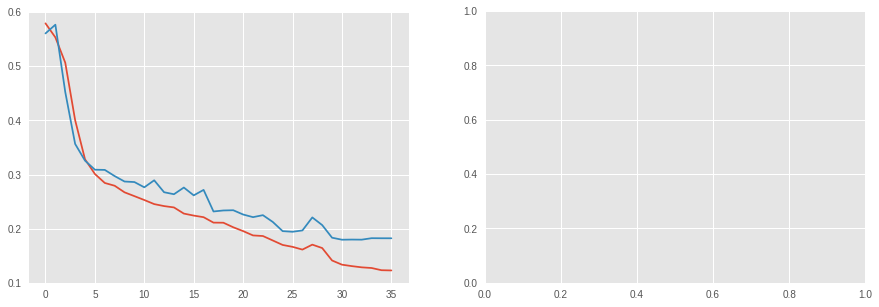

In [0]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(results.epoch, results.history["loss"], label="Train loss")
ax_loss.plot(results.epoch, results.history["val_loss"], label="Validation loss")
ax_acc.plot(results.epoch, results.history["mean_iou"], label="Train accuracy")
ax_acc.plot(results.epoch, results.history["val_mean_iou"], label="Validation accuracy")

In [0]:
model.load_weights("./model-tgs-salt-1gpu.h5")


OSError: ignored

In [0]:
preds_valid = model.predict({'img': X_val, 'feat': depth_test})


Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

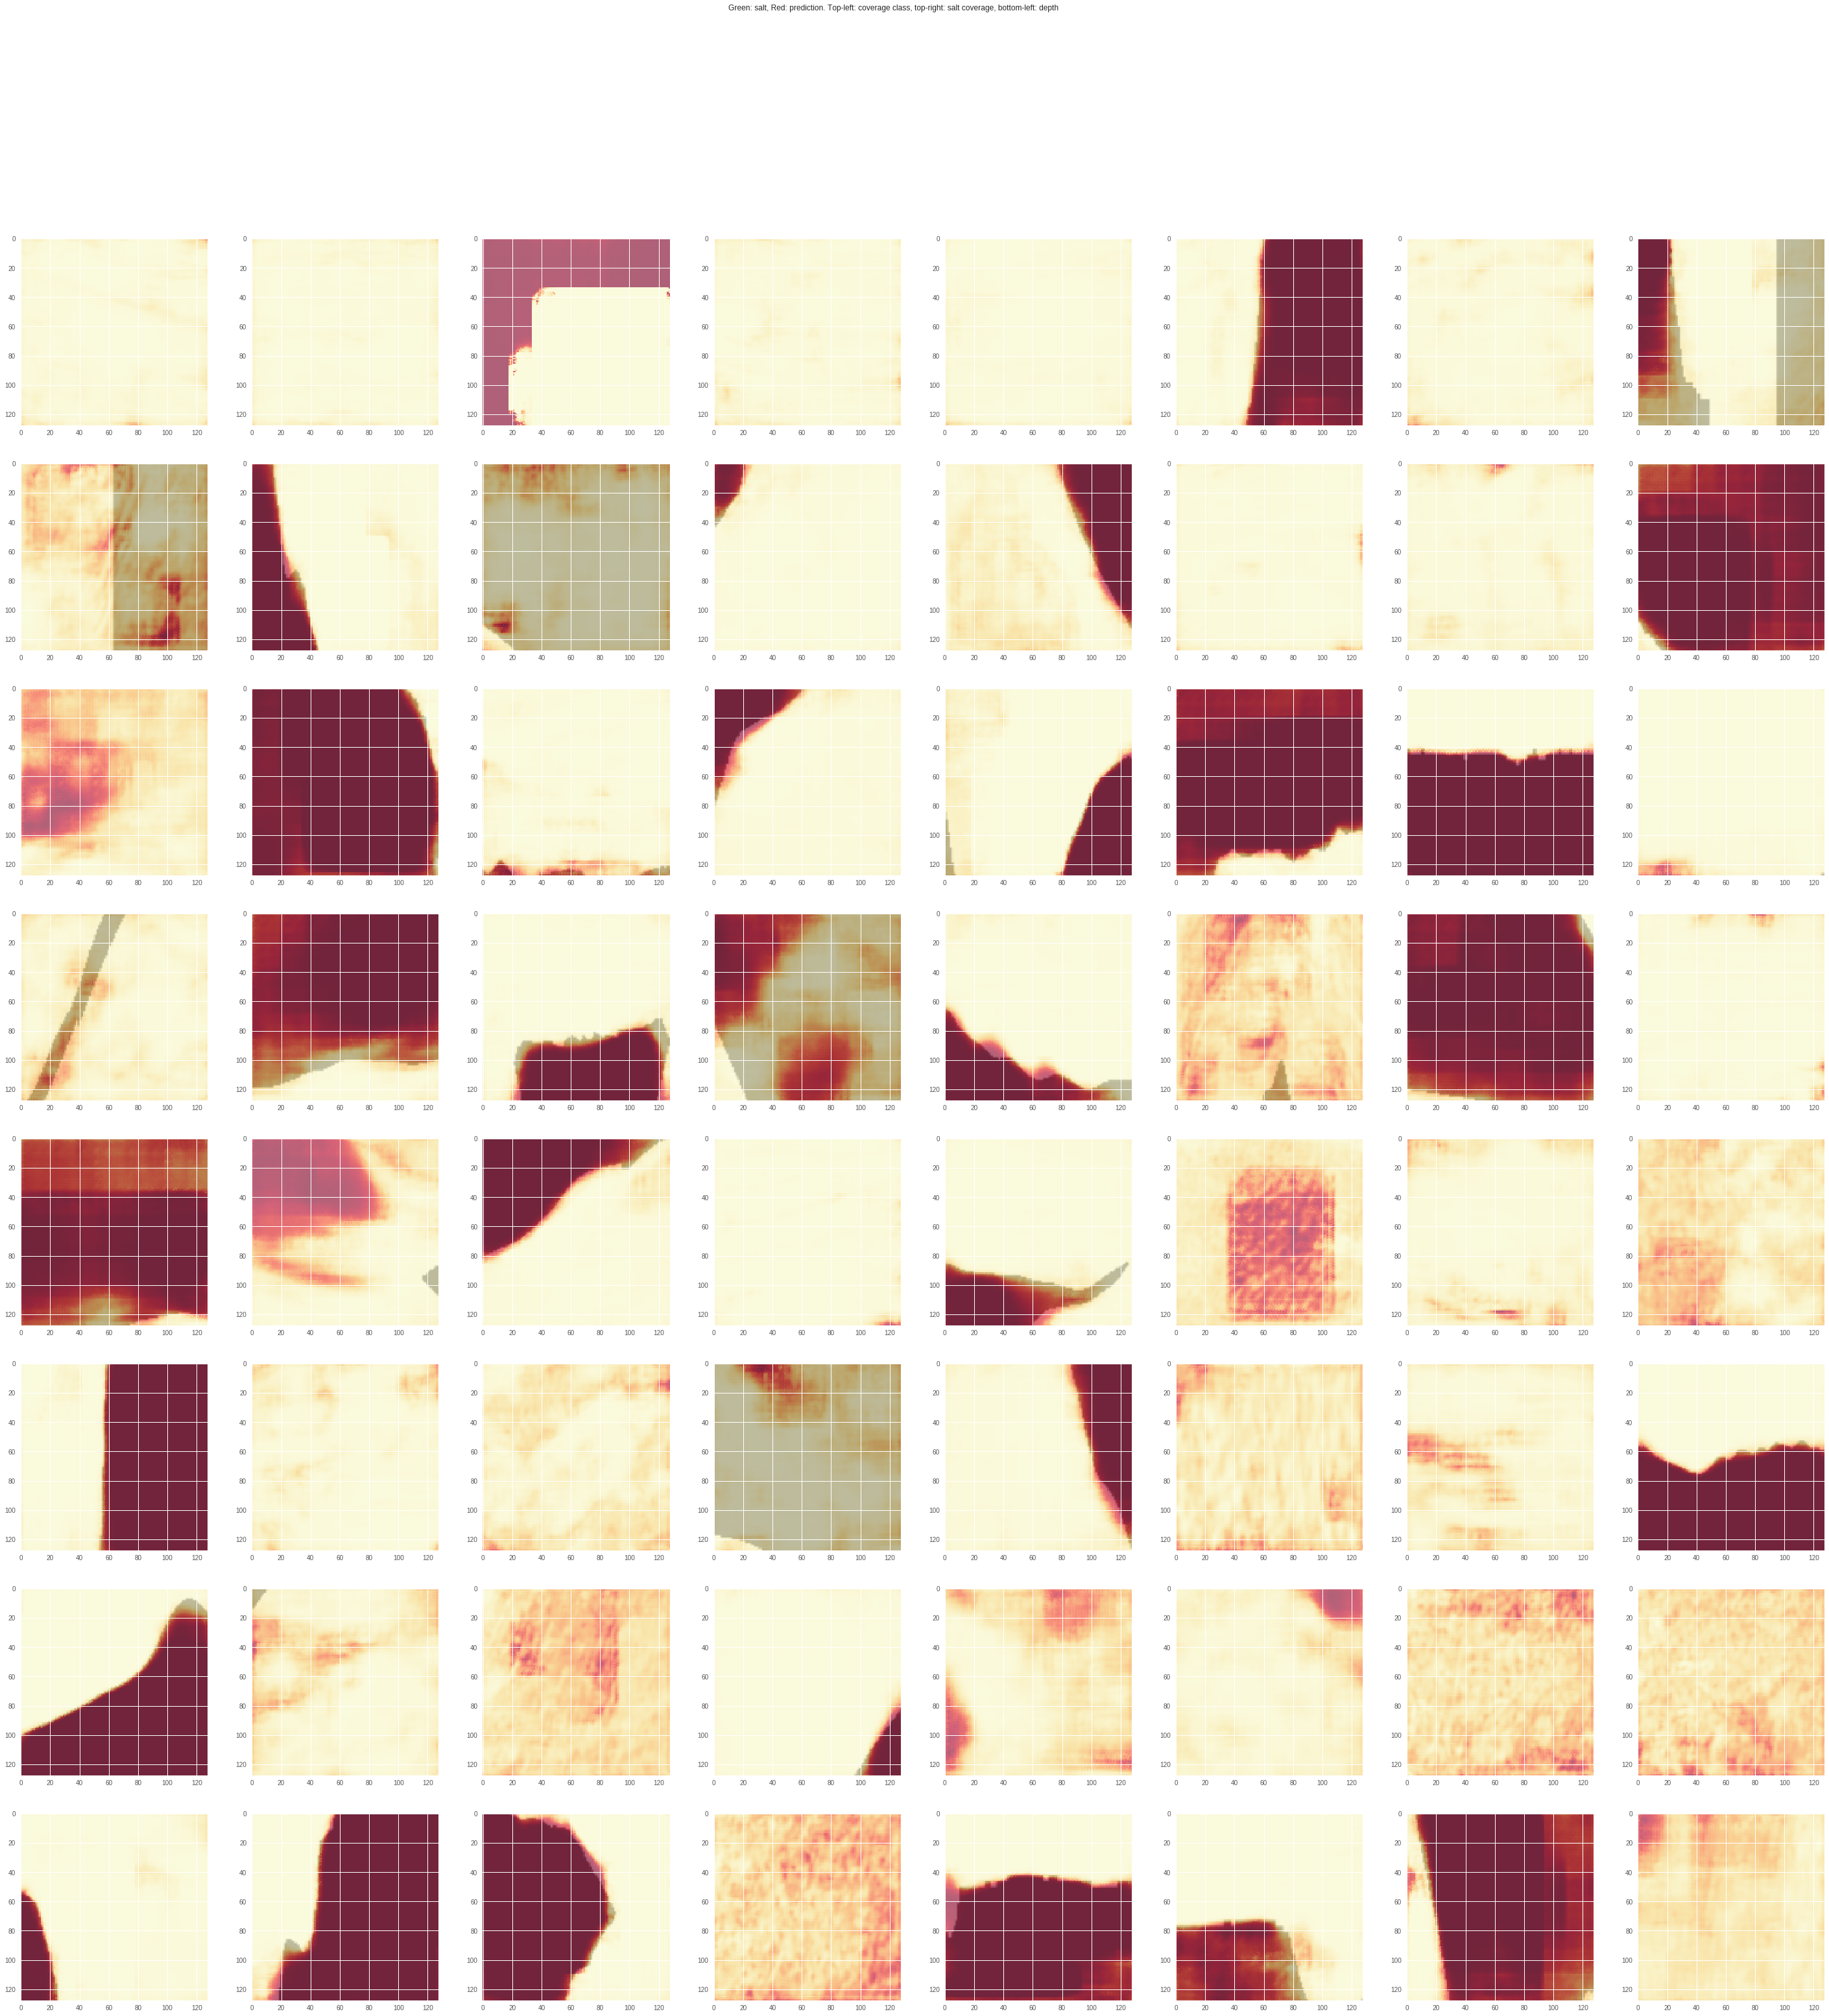

In [0]:
fig = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(64):
    sub = fig.add_subplot(8, 8, i + 1)
    #, interpolation='nearest'    
    img = X_val[i,:,:,0]
    mask = y_val[i,:,:,0]
    pred = preds_valid[i,:,:,0]
    #ax = axs[int(idx / grid_width), idx % grid_width]
    #sub.imshow(img, cmap="Greys")
    sub.imshow(mask, alpha=0.6, cmap="binary")
    sub.imshow(pred, alpha=0.6, cmap="YlOrRd")
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue

        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = np.sum(intersection > 0) / np.sum(union > 0)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

iou_val = get_iou_vector(y_val,preds_valid)
print("IoU: {}".format(iou_val))

IoU: 0.13637500000000002


**deleting unused variables**

In [0]:
del X_tr, y_tr
gc.collect()

2688

# Submission

In [0]:
#input_dim = [[1]] 
Iou_val = "Test"

salt_parameters["load_test_data"] = True

salt_parser = SaltParser(**salt_parameters)

salt_parser.initialize_data()
X_test, test_df = salt_parser.load_data()  # X_test

# Run name
run_name = '{}_grayscale{}_pad{}_size{}_IoU{}'.format(
    'Unet',
    int(salt_parameters['grayscale']),
    int(salt_parameters['pad_images']),
    input_dim[0],
    Iou_val)

print('Run name: {}'.format(run_name))


  1%|          | 174/18000 [00:00<00:10, 1738.29it/s]

Loading test set.


100%|██████████| 18000/18000 [00:10<00:00, 1744.71it/s]


Test set ready.
X_test shape: (18000, 128, 128, 3)
X_test - min: 0, max: 255
Run name: Unet_grayscale0_pad0_size128_IoUTest


In [0]:
if normalize or True:
    X_test = X_test / 255.
    print('X_test - min: {}, max: {}'.format(np.min(X_test), np.max(X_test)))
    print('Test set: {}'.format(X_test.shape))
    
X_test = X_test.astype(np.float32)
X_test.shape

X_test - min: 0.0, max: 1.0
Test set: (18000, 128, 128, 3)


(18000, 128, 128, 3)

In [0]:
preds_test = model.predict({'img': X_test, 'feat': test_df.z.values
})


In [0]:
X_test[0].shape

(128, 128, 3)

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

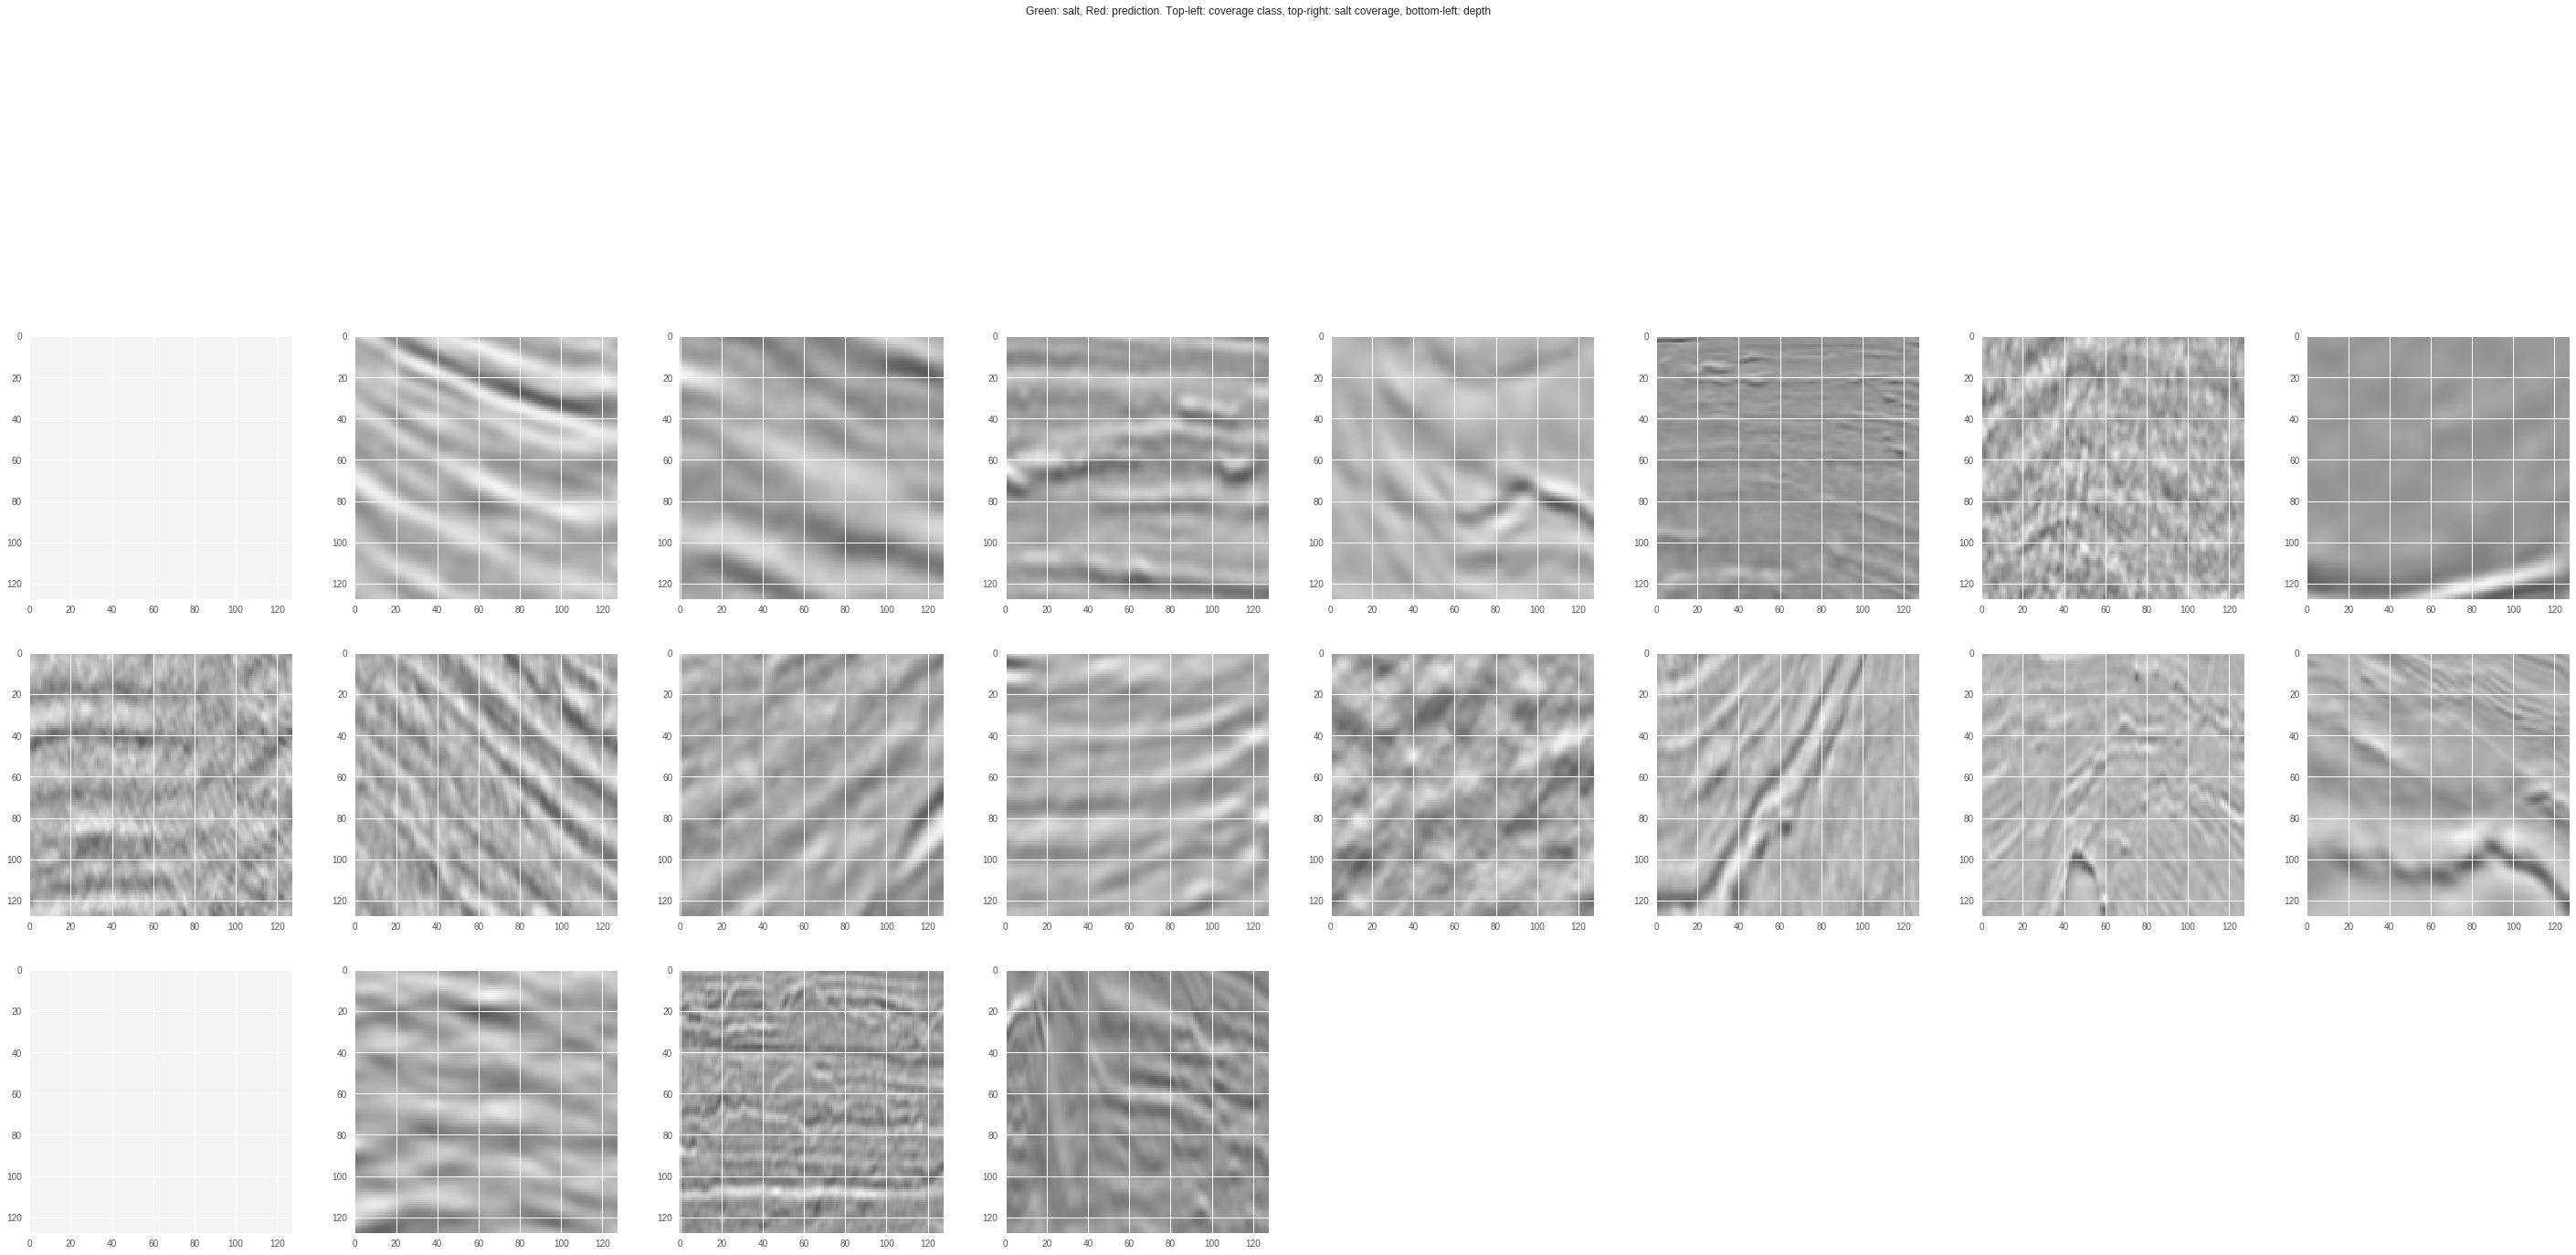

In [0]:
fig = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(20):
    sub = fig.add_subplot(8, 8, i + 1)
    #, interpolation='nearest'    
    img = X_test[i,:,:,0]
    pred = preds_test[i,:,:,0]
    #ax = axs[int(idx / grid_width), idx % grid_width]
    #sub.imshow(img, cmap="Greys")
    sub.imshow(img, alpha=0.6, cmap="binary")
    #sub.imshow(pred, alpha=0.99, cmap="Greens")
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [0]:
if True:
  del X_test
  gc.collect()

y_pred_test_rle = salt_parser.predictions_rle_encode(
    preds_test, confidence_threshold_best=0.5)

submission = salt_parser.generate_submission(y_pred_test_rle)


  0%|          | 30/18000 [00:00<01:00, 299.45it/s]

Test predictions shape: (18000, 101, 101)


100%|██████████| 18000/18000 [01:02<00:00, 288.87it/s]


In [0]:
if save or True:
    submission.to_csv('submission_{}.csv'.format(run_name))

In [0]:
if submit or True:
  !kaggle competitions submit -c tgs-salt-identification-challenge -f 'submission_Unet_grayscale0_pad0_size128_IoUTest.csv' -m "0.7178"



Successfully submitted to TGS Salt Identification Challenge

0

In [0]:
#!kill -9 -1